In [30]:
!pip install scikit-optimize

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [32]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [26]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [48]:
codes, categories = pd.factorize(df['bulk_labels'])

# build one-hot
y = np.eye(len(categories), dtype=int)[codes]
X = df.drop('bulk_labels', axis=1).values.astype(float)

np.random.seed(100)
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

n = int(0.8 * len(X))
X_train, y_train = X[:n], y[:n]
X_test,  y_test  = X[n:],  y[n:]


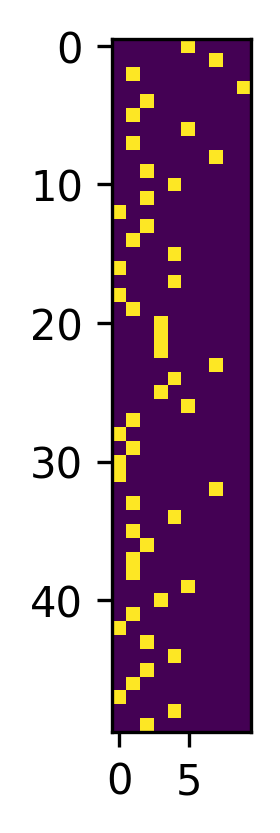

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

##do a search for parameter values, going through a loop, use

##from skopt import BayesSearchCV

##try just doing XGBoost if random forest can't go above 80%

In [51]:
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier

In [35]:
#random forest classfier
y_train_classifier = np.argmax(y_train, axis=1)
X_train_classifier, X_val, y_train_classifier, y_val = train_test_split(
    X_train, y_train_classifier, test_size=0.20, random_state=3, stratify=y_train_classifier
)

# 2. bayesian optimization search space
search_spaces = {
    'n_estimators': (10, 200),
    'max_depth': (3, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': ['sqrt', 'log2', None]
}

bayes_search = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    search_spaces,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

#fit and Evaluate
bayes_search.fit(X_train_classifier, y_train_classifier)
print("Best Hyperparameters:", bayes_search.best_params_)
print("Best CV Accuracy:", bayes_search.best_score_)

final_rfc = RandomForestClassifier(**bayes_search.best_params_, random_state=42)
final_rfc.fit(X_train, np.argmax(y_train, axis=1))
y_test_pred = final_rfc.predict(X_test)
final_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Final Test Accuracy: {final_accuracy:.2f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [41]:
#create classifier with best parameters

final_rfc = RandomForestClassifier(**bayes_search.best_params_, random_state=42)
final_rfc.fit(X_train, np.argmax(y_train, axis=1))

# classifier with all best parameters
print(final_rfc)

RandomForestClassifier(max_depth=24, min_samples_split=10, n_estimators=200,
                       random_state=42)


In [46]:
#evaluate on train data
y_test_pred = final_rfc.predict(X_test)
final_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Final Test Accuracy: {final_accuracy:.2f}")

Final Test Accuracy: 0.81


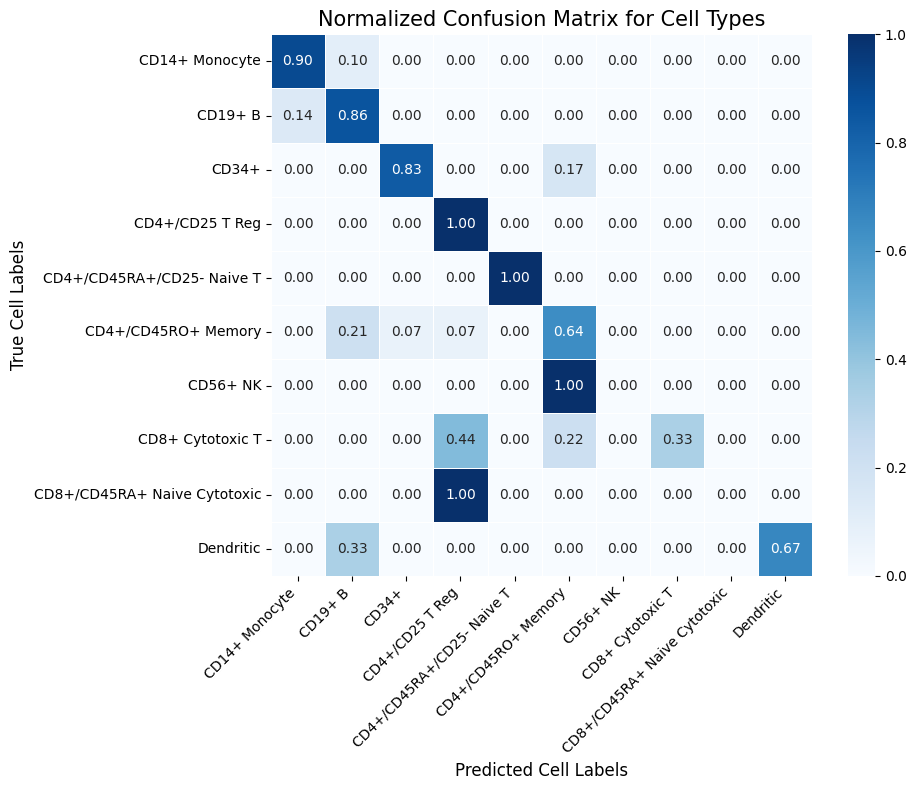

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)

cm_normalized = normalize(cm, axis=1, norm='l1')

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", linewidths=.5, square=True, cmap='Blues', ax=ax)

ax.set_ylabel('True Cell Labels', fontsize=12)
ax.set_xlabel('Predicted Cell Labels', fontsize=12)
ax.set_title('Normalized Confusion Matrix for Cell Types', fontsize=15)

names = ['CD14+ Monocyte', 'CD19+ B', 'CD34+', 'CD4+/CD25 T Reg', 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RO+ Memory', 'CD56+ NK', 'CD8+ Cytotoxic T', 'CD8+/CD45RA+ Naive Cytotoxic', 'Dendritic']

ax.set_xticklabels(names, rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(names, rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

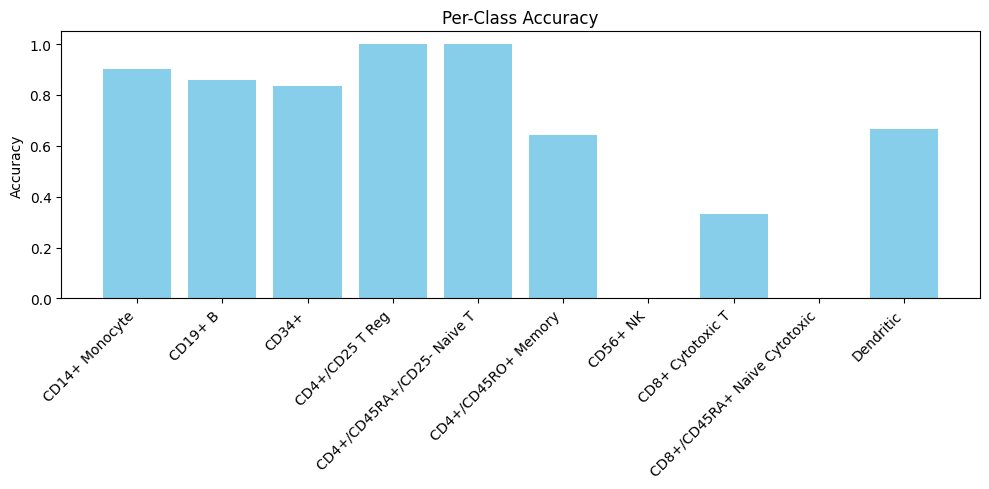

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# true/predicted labels as integers
y_true = np.argmax(y_test, axis=1)
y_pred = final_rfc.predict(X_test)

cm = confusion_matrix(y_true, y_pred)
per_class_acc = np.diag(cm) / cm.sum(axis=1)

plt.figure(figsize=(10, 5))
plt.bar(names, per_class_acc, color='skyblue')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


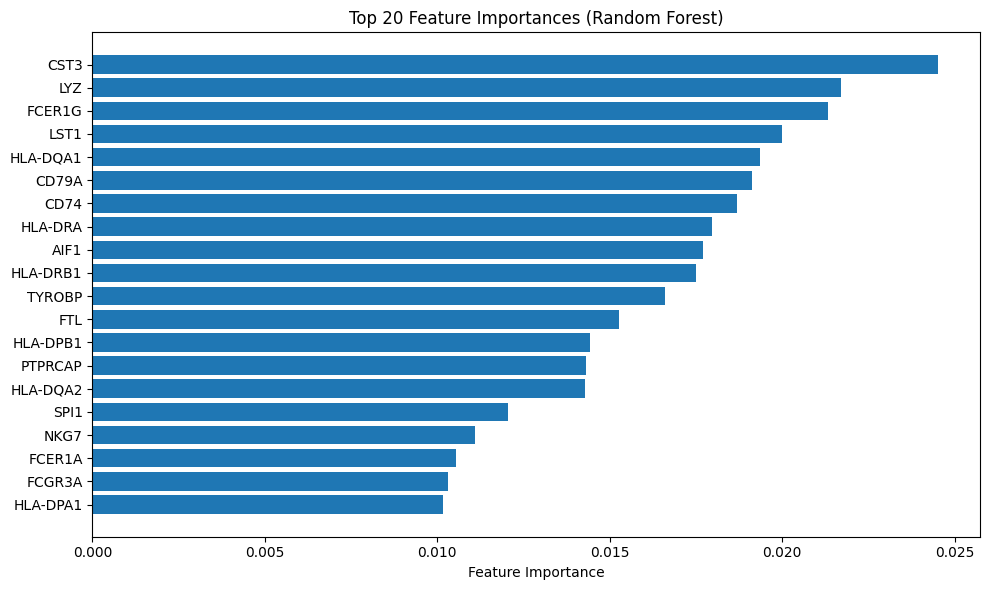

In [53]:
importances = final_rfc.feature_importances_
indices = np.argsort(importances)[-20:]  #top 20 features
plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), np.array(df.drop('bulk_labels', axis=1).columns)[indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()
